In [1]:
# Custom functions
import FPL_data
import FPL_ml

# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
from IPython.display import HTML

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

Use our custom function to load the data from disk

In [2]:
week_number, plyr_df, team_df, next_game_df, history_df = FPL_data.load_FPL_data(38)

In [3]:
history_df.columns

Index(['assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards', 'player_id'],
      dtype='object')

Let's try predicting gameweek 10, but training on data from weeks 1-8, then using 9 to predict

In [4]:
predict_week = 10

X_train = FPL_ml.data_prep(1,history_df,team_df,plyr_df)
print(X_train.shape[0])
for i in range(2,predict_week):
    X_train = X_train.append(FPL_ml.data_prep(i,history_df,team_df,plyr_df))
    print(X_train.shape[0])

(511,)
(511, 84)
[ 0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  5.  0.  1.  2.  0.  6.
  2.  0.  0.  5. 10.  0.  5.  6.  0.  6.  3.  0.  0.  2.  2.  2.  1.  0.
  0.  3.  1.  1.  2.  0.  0.  0.  1.  0.  2.  0.  2.  0.  2.  1.  0.  2.
 -1.  1.  0.  1.  0.  0.  0.  1.  2.  0.  0.  2.  0.  0.  2.  2.  1.  1.
  0.  2.  0.  4.  0.  7.  1.  0.  0.  0.  0.  2.  5.  2.  1.  0.  1.  5.
 13.  1.  0.  1.  0.  0.  1. -3.  2.  0.  6.  0.  0.  0. -1.  6.  3.  2.
  0.  0.  2.  2.  1.  0.  2.  0.  1.  1. -1.  0.  0.  0.  0.  1.  1.  2.
  0.  0.  0.  0.  1.  1.  0.  2.  6.  0.  0.  6.  0.  7.  0.  0.  1.  0.
  0.  8.  0.  1.  0.  0.  0.  0.  0.  3.  3.  1.  0.  1.  5.  2.  9.  0.
  9.  6.  6.  0.  0.  0.  0.  0. 10.  6.  1.  0.  3.  0.  0.  0.  0.  0.
  3.  3.  2.  1.  0.  4.  0. 12.  2.  0. -1.  0.  0.  0.  0.  0.  0.  3.
  5.  5.  0.  0.  1.  1.  0.  2.  0.  0. 13.  0.  6.  0.  0.  0.  1.  1.
  0.  1.  1.  0.  0.  1.  0.  0.  2.  0.  5.  0.  0.  6.  0.  2.  0. 11.
 12.  0.  0.  1.  0.  6.  0.  6.  

In [5]:
X_train.columns

Index(['assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id_x', 'influence', 'key_passes',
       'loaned_in', 'loaned_out', 'minutes', 'offside', 'open_play_crosses',
       'opponent_team', 'own_goals', 'penalties_conceded', 'penalties_missed',
       'penalties_saved', 'recoveries', 'red_cards', 'round', 'saves',
       'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'winning_goals',
       'yellow_cards', 'player_id', 'total_points_next_week', 'id_y',
       'squad_number', 'team', 'element_type', 'id', 'strength',


In [6]:
X_train.describe()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,...,avg_last_10wks,avg_last_allwks,max_last_3wks,max_last_5wks,max_last_10wks,max_allwks,min_last_3wks,min_last_5wks,min_last_10wks,min_allwks
count,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,...,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000
mean,0.049685,19.209404,0.051866,0.039263,0.138148,8.222734,0.168202,1.753272,15.239699,6.336476,...,1.620579,1.620579,2.989578,3.310228,3.495153,3.495153,0.622152,0.542414,0.507513,0.507513
std,0.239603,23.443389,0.246626,0.213280,0.553393,10.920365,0.374091,3.055877,20.090462,12.080375,...,1.989872,1.989872,3.715734,3.912959,4.024633,4.024633,1.412321,1.375110,1.379791,1.379791
min,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,10.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,7.000000,0.200000,...,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,32.000000,0.000000,0.000000,0.000000,14.000000,0.000000,2.000000,24.000000,8.300000,...,2.666667,2.666667,6.000000,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,130.000000,3.000000,3.000000,3.000000,96.000000,1.000000,23.000000,120.000000,95.200000,...,15.000000,15.000000,20.000000,20.000000,20.000000,20.000000,15.000000,15.000000,15.000000,15.000000


Check for columns with NULLs

In [7]:
X_train.columns[X_train.isnull().any()]

Index([], dtype='object')

In [8]:
HTML(X_train[X_train['opponent_team_next_week'].isnull()].to_html())

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id_x,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,player_id,total_points_next_week,id_y,squad_number,team,element_type,id,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,opponent_team_next_week,id_next_week,strength_next_week,strength_attack_away_next_week,strength_attack_home_next_week,strength_defence_away_next_week,strength_defence_home_next_week,strength_overall_away_next_week,strength_overall_home_next_week,avg_last_3wks,avg_last_5wks,avg_last_10wks,avg_last_allwks,max_last_3wks,max_last_5wks,max_last_10wks,max_allwks,min_last_3wks,min_last_5wks,min_last_10wks,min_allwks


In [9]:
y_train = X_train.pop('total_points_next_week')

# Build model

In [12]:
model = RandomForestRegressor(random_state=42)
model = model.fit(X_train,y_train)

In [13]:
X = FPL_ml.data_prep(predict_week,history_df,team_df,plyr_df)
y = X.pop('total_points_next_week')
y_predict = model.predict(X)
print('Mean squared error: {0}'.format(mean_squared_error(y,y_predict)))

(563,)
(563, 84)
[ 0.    2.5   0.    1.    3.    0.    3.75  1.5   0.    6.25  2.    1.5
  5.5   5.    0.25  5.    0.    6.    1.    0.25  2.75  0.75  3.75  1.
  0.75  0.5   0.    3.    3.25  0.    0.    2.75  1.    3.    2.5   0.
  0.    3.75  0.25  1.    4.    5.    0.5   0.    1.25  2.    0.25  0.25
  2.    0.75  1.    1.    0.    3.5   2.5   3.5   0.25  3.    2.    0.
  0.    3.5   2.25  0.    0.    1.75  0.    0.    0.    5.    5.5   0.
  0.    0.    0.    4.25  4.75  5.25  3.25  0.    0.    1.25  0.    2.5
  2.    5.    2.5   0.5   0.    2.    0.25  1.25  1.25  3.25  0.    0.
  4.    1.    2.5   2.5   2.    0.25  2.25  5.    3.    2.    2.75  1.5
  4.25  0.    0.5   0.    3.75  0.    0.25  1.5   0.25  0.75  1.    0.
  0.    0.    1.5   1.    0.75  4.25  1.25  0.    3.    1.    3.    3.5
  0.    0.    2.    0.    0.    1.    0.    0.75  0.    0.    0.75  0.5
  0.25  1.    0.    0.25  0.    0.    3.25  0.    0.25  1.    1.25  1.
  0.25  0.    2.5   0.25  4.5   0.    3.75  0.5   1. 

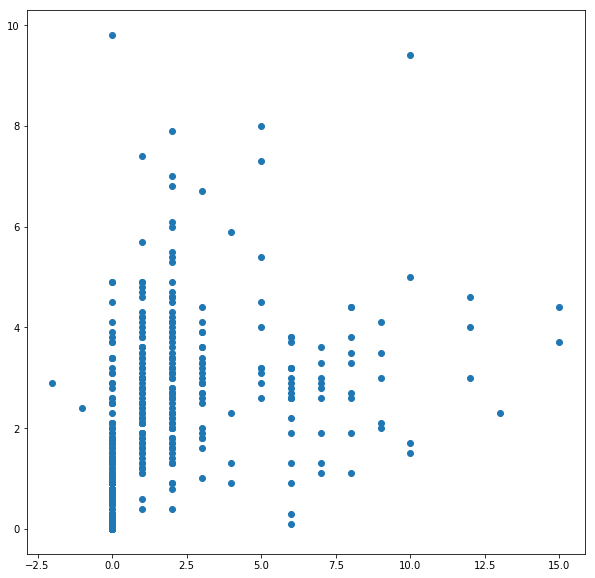

In [16]:
plt.scatter(y,y_predict);

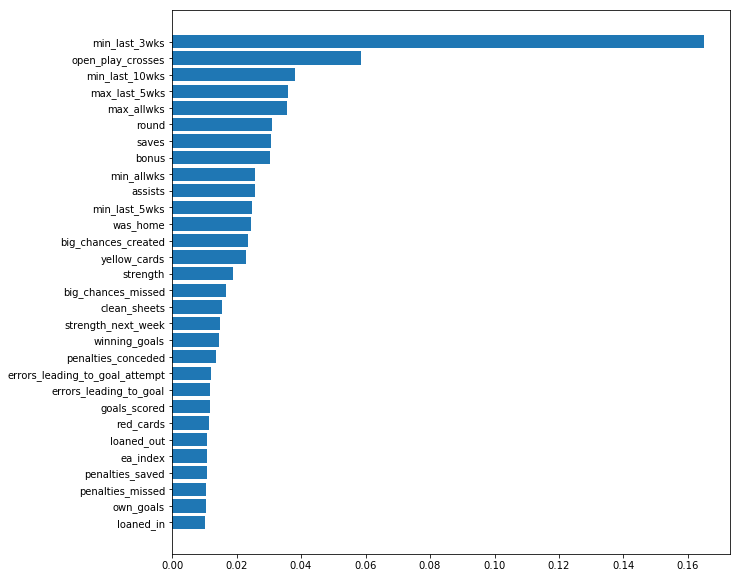

In [17]:
FPL_ml.plot_feature_importance(X,model)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Team should be one-hot encoded for best results
enc = OneHotEncoder()
enc.fit(X['opponent_team'].values.reshape(-1,1))
    

In [ ]:
enc.n_values_

In [ ]:
enc.feature_indices_

In [ ]:
X_teams = enc.transform(X['opponent_team'].values.reshape(-1,1)).toarray()

In [ ]:
X_teams

In [ ]:
team_df.columns

In [ ]:
team_df

In [ ]:
next_game_df

In [ ]:
plyr_df[['team','team_code','id','first_name','second_name']]

In [ ]:
plyr_df.columns

In [ ]:
plt.scatter(X_train['strength_attack_home']-X_train['strength_defence_away_next_week'], y_train);

In [ ]:
X_train.columns

In [ ]:
X_train['opponent_team']